# Step 1 : Box plot (distribution #comments/each post among different facebook fans pages)

In [113]:
import pyes
import json
import pandas as pd
import seaborn as sns

def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

# Step 2 : Choose '麥當勞' '必勝客''肯德基' as fan pages

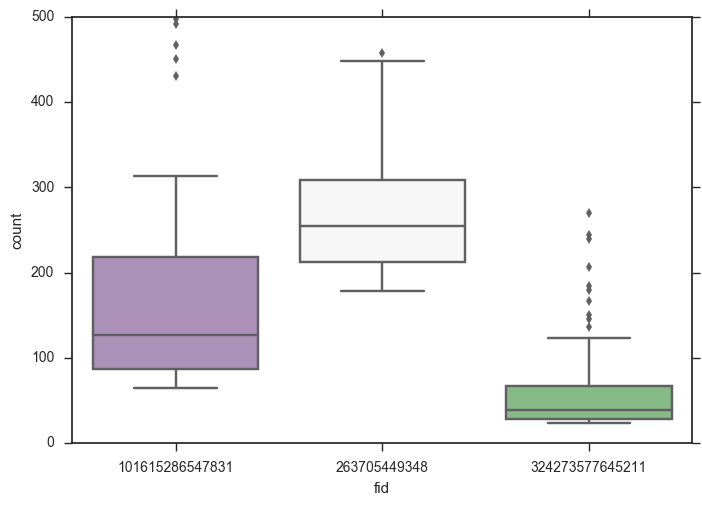

In [117]:
#assign the facebook fans page that you prefered
fids=['101615286547831','263705449348','324273577645211']

#elasticsearch repository provided by this course
host = '127.0.0.1:9200'

#output box plot PNG figure
pngFilePath="output.png"

#outlier threshold you want to filter (if you give minus ONE, none of outlier is filtered.)
outlierFilter=500

#obtain the result and save as "pngFilePath" given from you
boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

# Step 3 : Box plt(#post per month for specified page)

In [127]:
import pyes
import json
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound, pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #ESR = pyes.ESRange(field="created_at", from_value="2015-01-01T00:00:00+0000", to_value="2015-12-31T23:59:59+0000", 
    #               include_lower=True ,include_upper=True)
    DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq)  
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
    #for data in result['month']:
        #print data['pid'] 
    #print len(json.dumps(result.aggs,indent=2))
    #return result
    #print json.dumps(result.aggs,indent=2)   
    #print len(result.aggs)
    #print result[0]
    #print json.dumps(result.aggs,indent=2) 
    #for fidpid_summary in result.aggs["pid"]["buckets"]:
    #    print fid + ',' + str(fidpid_summary["doc_count"])
#parsed_input = json.dumps(aa(fid1).aggs,indent=2)
#aa(fid2)

#for i in range(0,len(aa(fid1).aggs["month"]["buckets"])):
#    print aa(fid1).aggs["month"]["buckets"][i]["doc_count"]
    data = []
    for r in result.aggs["month"]["buckets"]:
        #print json.dumps(r,indent=2) 
        for pid in r["pid"]["buckets"]:
            #print json.dumps(pid,indent=2) 
            #print pid
            MonthofYear = datetime.datetime.strptime(r["key_as_string"],"%Y-%m-%dT%H:%M:%S.%fZ").strftime('%m/%Y')
            MonthofYear_simple = MonthofYear[:3]+MonthofYear[5:]
            #print pid
            data.append([MonthofYear_simple, pid["doc_count"], pid["key"]])
    #print json.dumps(data,indent=2)
    df = pd.DataFrame(data, columns=['month', 'count', 'pid'])
    sns.set(style="ticks")
    fig, ax = sns.plt.subplots()
    fig.set_size_inches(13.7,8.27)
    sns_plot = sns.boxplot(x="month", y="count", data=df, palette="RdBu")
    plt.ylim(lower_bound,upper_bound)
    plt.xticks(size=7)
    plt.show()
    fig = sns_plot.get_figure()
    #plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)
    #fig.savefig("output3.png")

# Step 4 : Assign '麥當勞' '必勝客''肯德基' as fan pages
## '麥當勞'

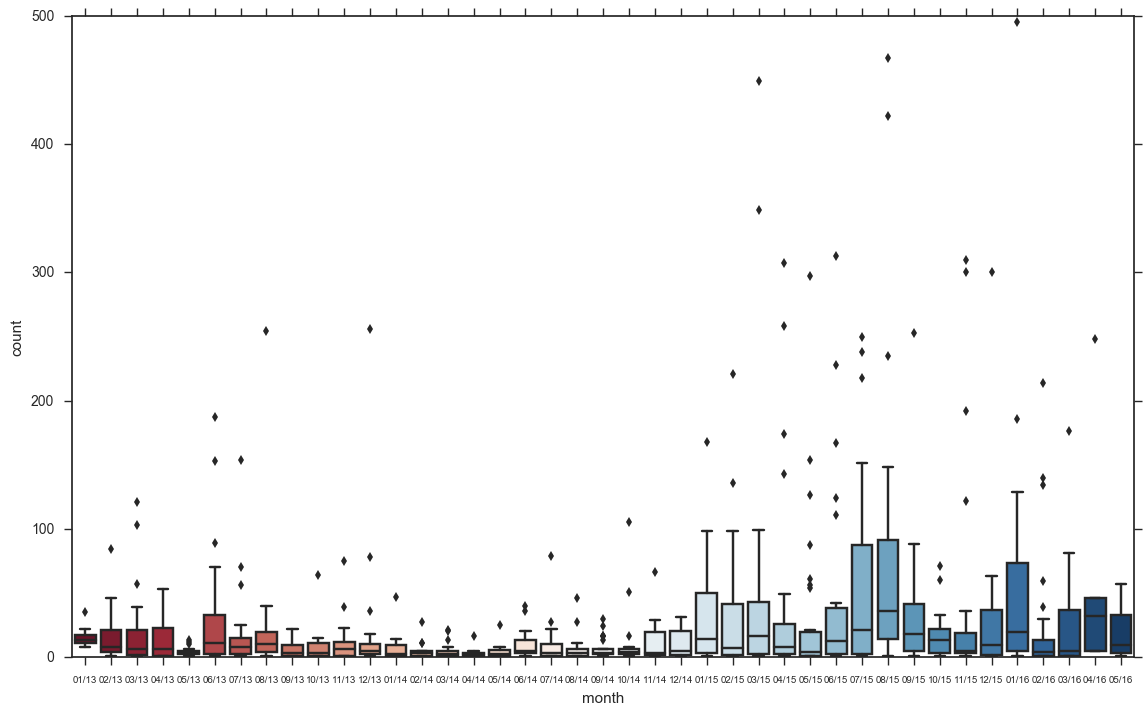

In [130]:
host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 500
fid="101615286547831"
pngFilePath = "output2.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound, pngFilePath)

## '必勝客'

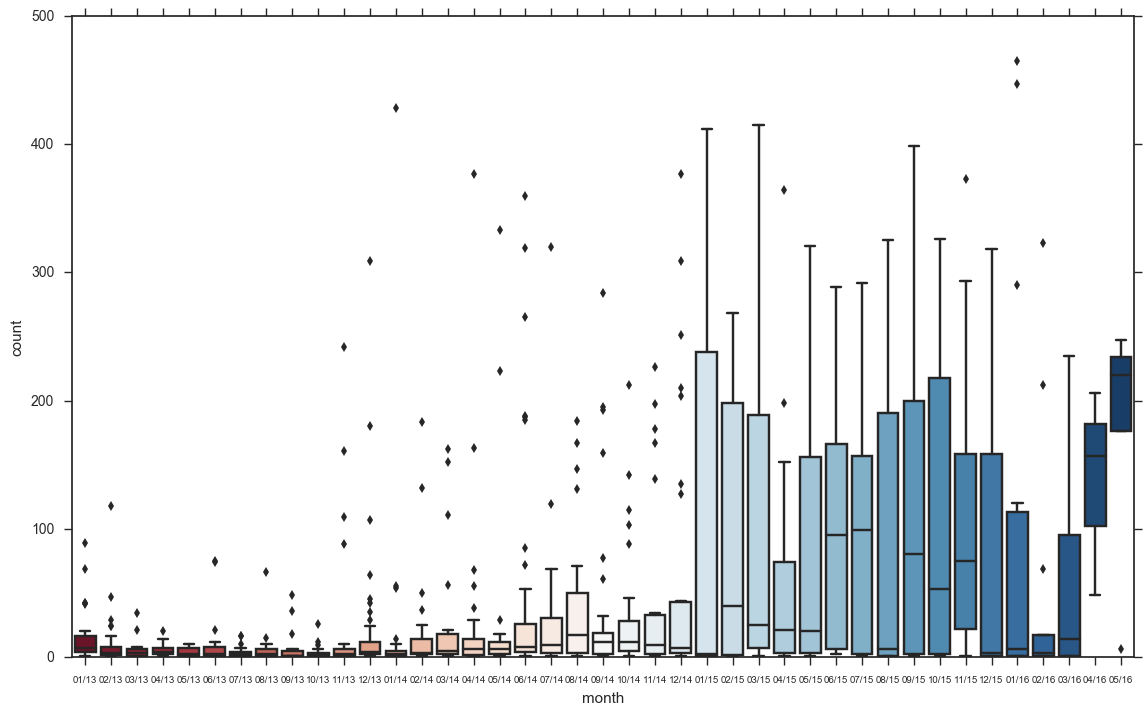

In [131]:
host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 500
fid="263705449348"
pngFilePath = "output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

## '肯德基'

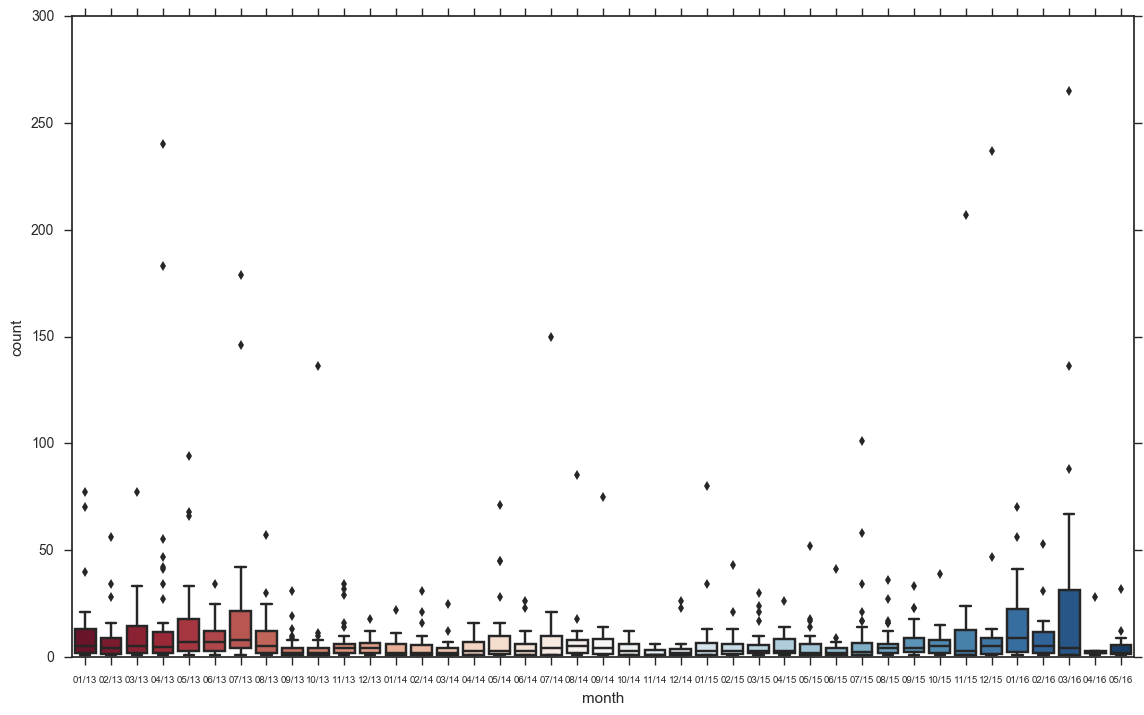

In [132]:
host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 300
fid="324273577645211"
pngFilePath = "output4.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

# Step 5 : Get User-Post frequence matrix
## input {es address, row name, column name, fans page ID}

In [141]:
import pyes
import json
import elasticsearch

def getUserPostFreqMatrix(es_address,row,column,fid):
    es = elasticsearch.Elasticsearch([{'host':es_address,'port':9200}])
    results = es.search(
    index="facebook_nested",
    doc_type="comment",
    
    body={
            "query": {
                "term": {"fid":fid}
            },
            "aggs":{
                "from_uid":{
                    "terms":{"field":row},
                    "aggs":{
                        "fid_pid":{"terms":{"field":column}}}}}})
    rc=200
    cc=200
    rowIndexList,colIndexList,matrix = [],[],[]
    rowcount=0
    colcount=0

    for user in results['aggregations']['from_uid']['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1
            #print json.dumps(user,indent=2)
        for post in user['fid_pid']['buckets']:
            #print json.dumps(post,indent=2)
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1
    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))
    #print matrix
    #print rowIndexList
    #print colIndexList
    for user in results['aggregations']['from_uid']['buckets']:
        if user["key"] in rowIndexList:
            for post in user['fid_pid']['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])]= float(post['doc_count'])
    return {"data":matrix, "col":colIndexList, "row":rowIndexList}
    
#print json.dumps(results,indent=2)


## '麥當勞'

In [160]:
es_address="127.0.0.1"
row="from.id"
column="fid_pid"
fid="101615286547831"
result = getUserPostFreqMatrix(es_address,row,column,fid)
#print result['data']

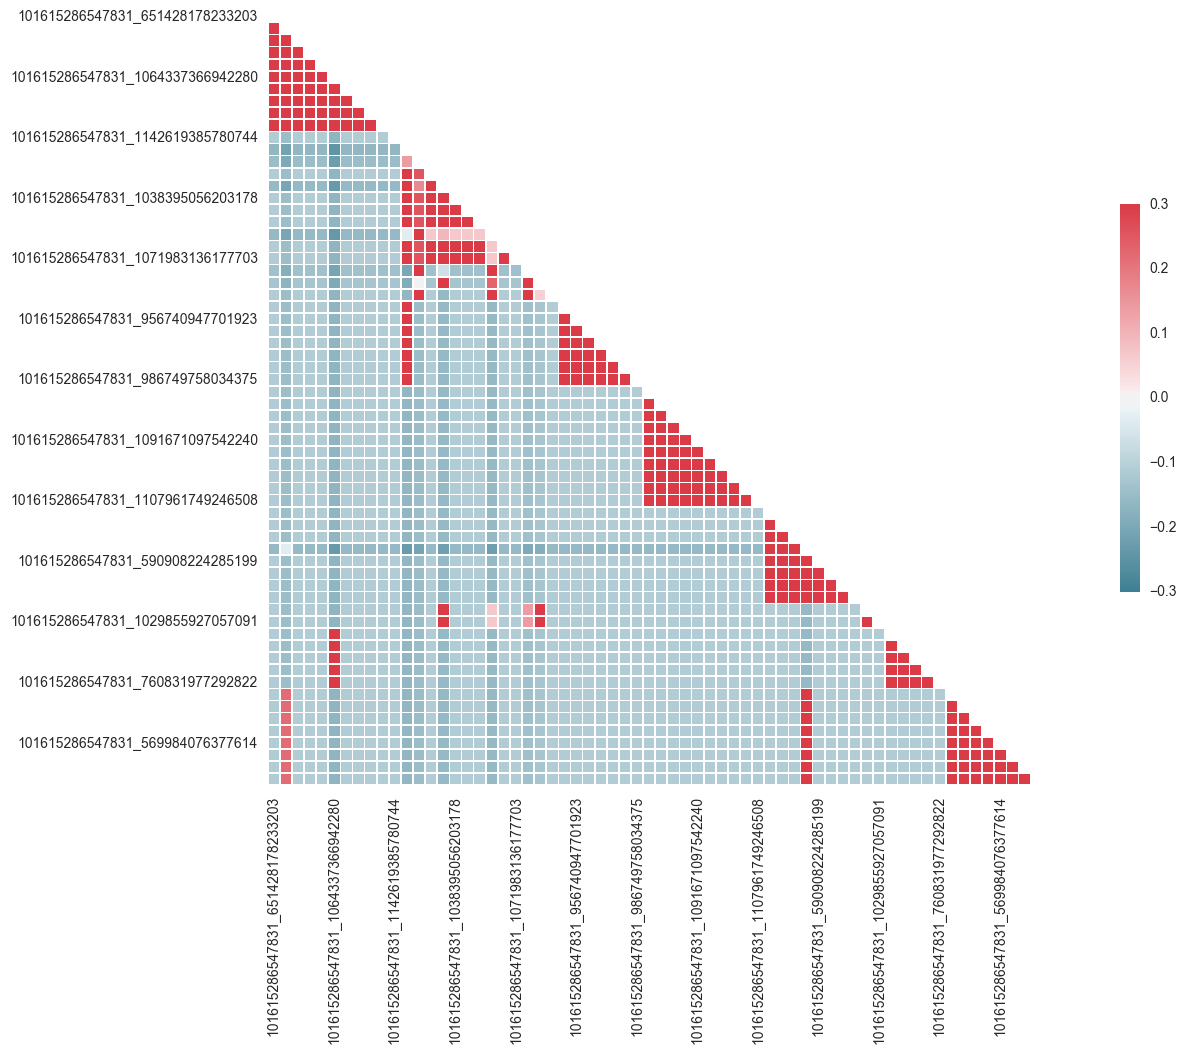

In [162]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                       square=True, xticklabels=5, 
                       yticklabels=5,linewidths=.5, 
                       cbar_kws={"shrink": .5}, ax=ax)
fig = sns_plot.get_figure()
fig.savefig("output_MD.png")

## '必勝客'

In [163]:
es_address="127.0.0.1"
row="from.id"
column="fid_pid"
fid="263705449348"
result = getUserPostFreqMatrix(es_address,row,column,fid)
#print result['data']

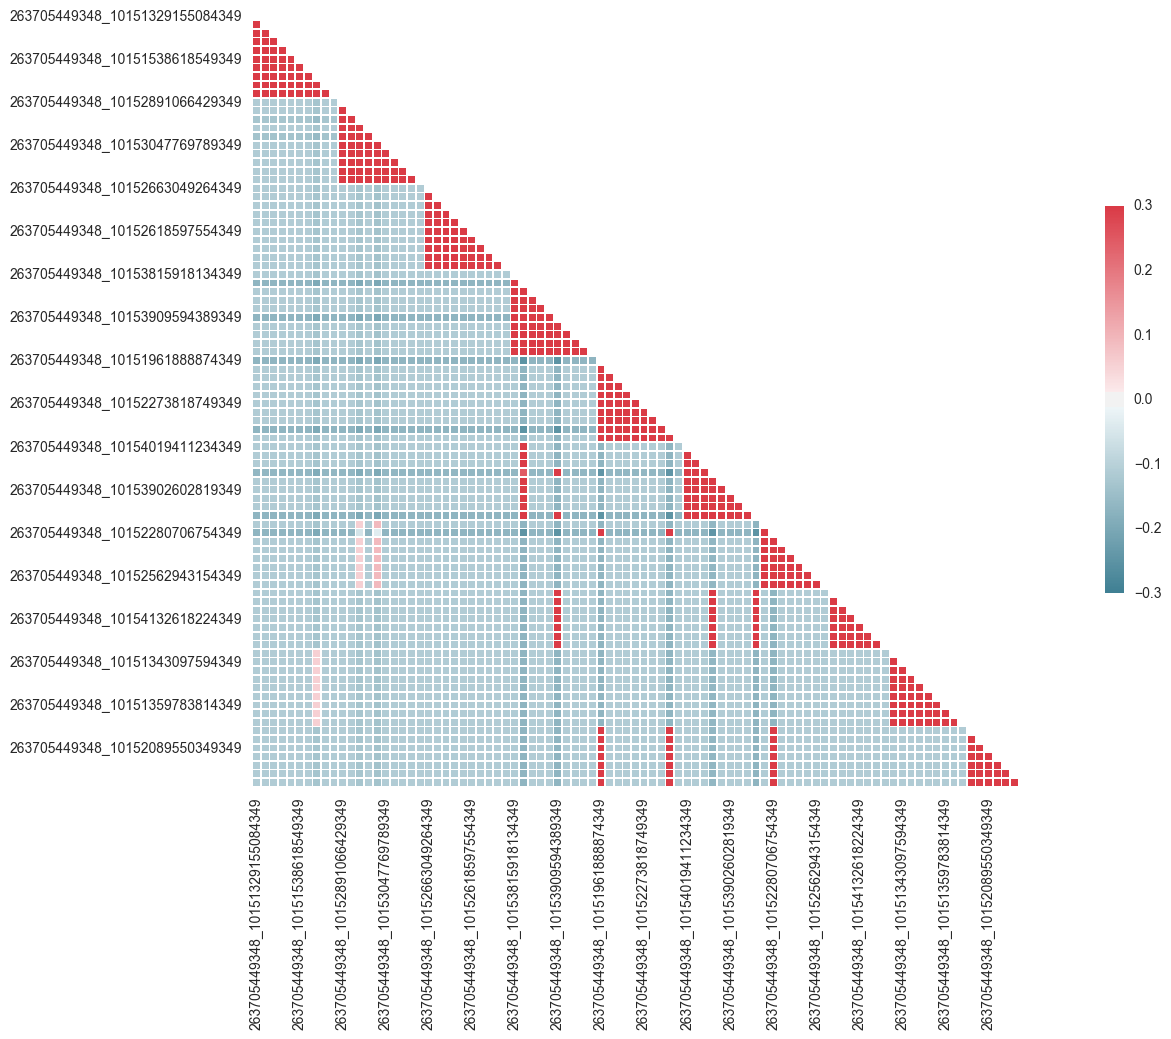

In [164]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
fig = sns_plot.get_figure()
fig.savefig("output_Win.png")

## '肯德基'

In [165]:
es_address="127.0.0.1"
row="from.id"
column="fid_pid"
fid="324273577645211"
result = getUserPostFreqMatrix(es_address,row,column,fid)
#print result['data']

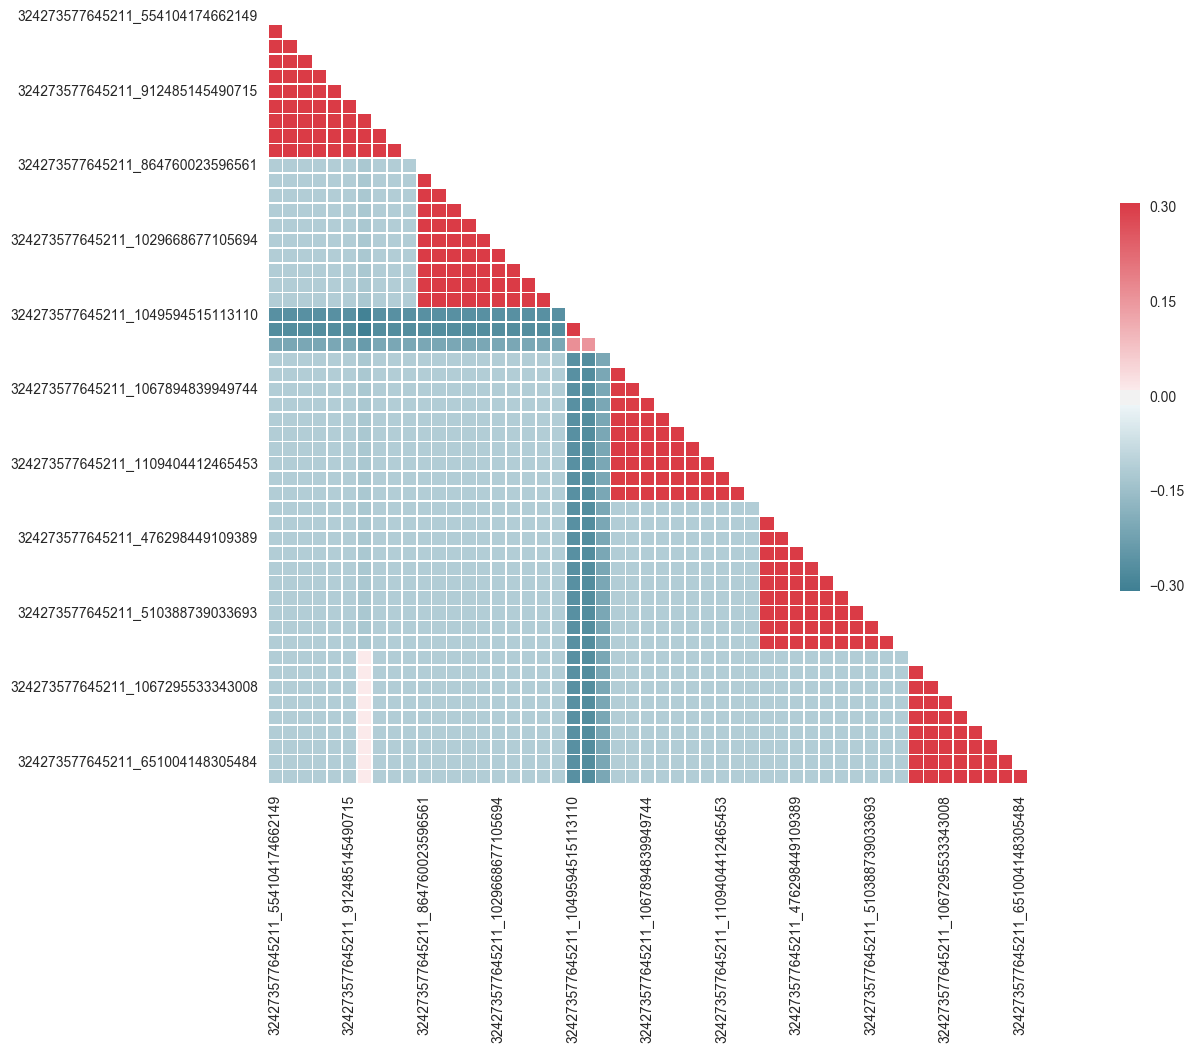

In [166]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
fig = sns_plot.get_figure()
fig.savefig("output_KFC.png")